In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime, date
from dateutil import tz
import glob

import matplotlib.patches as mpatches
from metpy.plots import USCOUNTIES
import geopandas
from cartopy import crs as ccrs

from Map import Map

In [39]:
WPC_DAY = 2
LOCATION = 'southeast'
STATE_MASK = 'SC'

In [40]:
def get_gdf(day, state_mask):
    gdf_mask = geopandas.read_file('../../gis/tl_2017_us_state/tl_2017_us_state.shp')
    cat_gdf = geopandas.read_file(f'https://ftp.wpc.ncep.noaa.gov/shapefiles/qpf/excessive/EXCESSIVERAIN_Day{day}_latest.zip', 
                                  mask=gdf_mask[gdf_mask.STUSPS==state_mask.upper()])

    # Setup filter. Decide which categories you want to plot. I want at least a slight.
    filt = (
        (cat_gdf['OUTLOOK'] == 'Marginal (5-10%)') |
        (cat_gdf['OUTLOOK'] == 'Slight (10-20%)') |
        (cat_gdf['OUTLOOK'] == 'Moderate (20-50%)') |
        (cat_gdf['OUTLOOK'] == 'High (> 50%)')
    )

    # Apply filter
    cat_gdf = cat_gdf[filt]
    return cat_gdf

cat_gdf = get_gdf(WPC_DAY, STATE_MASK)
cat_gdf

/Users/rhawthorne/miniconda3/envs/metpy_v1/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,PRODUCT,VALID_TIME,OUTLOOK,ISSUE_TIME,START_TIME,END_TIME,geometry
0,Day 2 Excessive Rainfall Potential Forecast,12Z 09/20/21 - 12Z 09/21/21,Marginal (5-10%),2021-09-19 06:58:00,2021-09-20 12:00:00,2021-09-21 12:00:00,"MULTIPOLYGON (((-79.51944 33.01364, -79.51984 ..."
1,Day 2 Excessive Rainfall Potential Forecast,12Z 09/20/21 - 12Z 09/21/21,Slight (10-20%),2021-09-19 06:58:00,2021-09-20 12:00:00,2021-09-21 12:00:00,"MULTIPOLYGON (((-81.01314 31.85187, -81.01462 ..."


In [41]:
def wpc_outlook_categories():
    return {
        'Marginal (5-10%)': ('green', 'Isolated'),
        'Slight (10-20%)': ('yellow', 'Scattered'),
        'Moderate (20-50%)': ('red', 'Numerous'),
        'High (> 50%)': ('magenta', 'Widespread')
    }

In [42]:
def convert_datetime_from_wpc_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

def get_valid_day(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%d %H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

def get_outlook_valid_time_info():
    start_time = cat_gdf.iloc[0]['START_TIME']
    end_time = cat_gdf.iloc[0]['END_TIME']
    
    valid_day = get_valid_day(start_time)
    start_time = convert_datetime_from_wpc_to_local(start_time)
    end_time = convert_datetime_from_wpc_to_local(end_time)
    
    return { 
        'valid_day': valid_day,
        'start_time': start_time,
        'end_time': end_time
    }

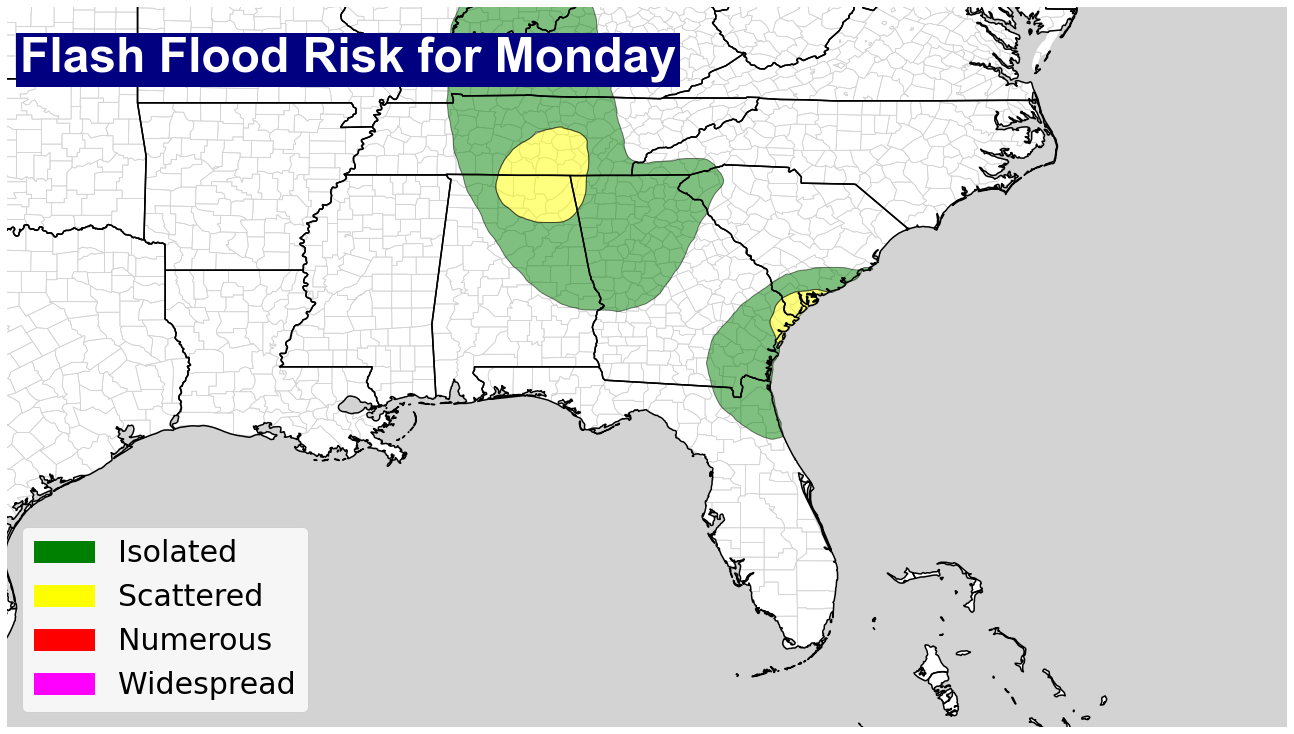

In [43]:
def any_risk_areas(geometries):
    '''Checks to see if there are any areas flagged for flash flooding'''
    return True if cat_gdf['geometry'].any() else False

def plot_legend(ax):
    legend_patches = []
    cat_plot_colors = wpc_outlook_categories()
    for risk in cat_plot_colors.keys():
        patch = mpatches.Patch(color=cat_plot_colors[risk][0], label=cat_plot_colors[risk][1])
        legend_patches.append(patch)
    ax.legend(handles=legend_patches, fontsize=30, loc='lower left')
    
def save_map_to_disk(fig):
    GRAPHICS_DIR = Path('.') / '..' / '..' / 'graphics' / 'wpc'
    fig.savefig(f'{GRAPHICS_DIR}/ero_day{WPC_DAY}_{LOCATION.lower()}.png', dpi=72)

def plot_risk_areas():
    new_map = Map(LOCATION)
    new_map.add_counties()
    new_map.add_title(f'Flash Flood Risk for {get_outlook_valid_time_info()["valid_day"]}')

    fig, ax = new_map.make_map()
    
    cat_plot_colors = wpc_outlook_categories()
    for key in cat_plot_colors.keys():
        geometries = cat_gdf[cat_gdf['OUTLOOK'] == key]
        ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(),
                          facecolor=cat_plot_colors[key][0], edgecolor='black',
                          alpha=0.5)
    plot_legend(ax)
    save_map_to_disk(fig)
        
def plot_wpc_outlook():
    if not any_risk_areas(cat_gdf['geometry']):
        return
    plot_risk_areas()
    
plot_wpc_outlook()